In [37]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import glob
import warnings
import matplotlib
import nc_time_axis
import cftime
from datetime import datetime
from cmip6_preprocessing.preprocessing import combined_preprocessing

xr.set_options(display_style='html')
plt.rcParams['figure.figsize'] = 5,2.5

import xskillscore as xs
import seaborn as sns
from mpl_toolkits.axes_grid.anchored_artists import AnchoredText


In [86]:
# we use this in our scatter plots

def textonly(ax, txt, fontsize = 14, loc = 2, *args, **kwargs):
    at = AnchoredText(txt,
                      prop=dict(size=fontsize), 
                      frameon=True,
                      loc=loc)
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.1")
    ax.add_artist(at)
    return at

### Define grid variables

In [39]:
file_dx = '/gws/nopw/j04/ukfafmip/users/enewsom/regrid_from_jonathan_thetoa/cmip5/dx_regrid.nc'
dx =  xr.open_dataset(file_dx).assign_attrs(source_id='model')
dx=combined_preprocessing(dx)
dx = dx['dx']

file_da = '/gws/nopw/j04/ukfafmip/users/enewsom/regrid_from_jonathan_thetoa/cmip5/area_regrid.nc'
da =  xr.open_dataset(file_da).assign_attrs(source_id='model')
da=combined_preprocessing(da)
area = da['cell_area']
dy= area/dx



### Open SST and OHU data and define lists of models

In [70]:

SST_change_cmip5 =  xr.open_dataarray('SST_change_cmip5.nc').rename('sst_anom')
SST_change_cmip6 =  xr.open_dataarray('SST_change_cmip6.nc').rename('sst_anom')
OHU_change_cmip5 =  xr.open_dataarray('OHU_change_cmip5.nc').rename('ohu_anom')
OHU_change_cmip6 =  xr.open_dataarray('OHU_change_cmip6.nc').rename('ohu_anom')

SST_change = xr.concat([SST_change_cmip5,SST_change_cmip6],dim='model')
OHU_change = xr.concat([OHU_change_cmip5,OHU_change_cmip6],dim='model')

models_cmip5=SST_change_cmip5.model
models_cmip6=SST_change_cmip6.model

#### Calculate OHUE for list of regions (global, mid-lat, N high lat, S high lat, Low lat)

In [66]:
ocean_mask=(SST_change/SST_change).isel(model=0)
delta_SST= (SST_change*area).sum(['x','y'])/((ocean_mask*area).sum(['x','y']))

shl_lats = slice(-90,-60)
nhl_lats = slice(60,90)
ll_lats = slice(-30,30)
ml_lats = slice(-60,60)

OHU_change_gl = (OHU_change*area).sum(['x','y']).assign_coords(surf_reg='global') 
OHUA  = (OHU_change*area)
OHU_change_ml = OHUA.sel(y=ml_lats).where(np.abs(OHUA.y)>30).sum(['x','y']).assign_coords(surf_reg='mid_lats')

OHU_change_shl = (OHU_change*area).sel(y=shl_lats).sum(['x','y']).assign_coords(surf_reg='so_highlats') 
OHU_change_nhl= (OHU_change*area).sel(y=nhl_lats).sum(['x','y']).assign_coords(surf_reg='nh_highlats') 
OHU_change_ll = (OHU_change*area).sel(y=ll_lats).sum(['x','y']).assign_coords(surf_reg='low_lats') 

delta_OHU= xr.concat([OHU_change_gl,OHU_change_ml,OHU_change_nhl,OHU_change_shl,OHU_change_ll],dim='surf_reg')
OHUE = delta_OHU/delta_SST/area.sum(['x','y']).rename('ohue')


### Make bar plot of global OHUE values

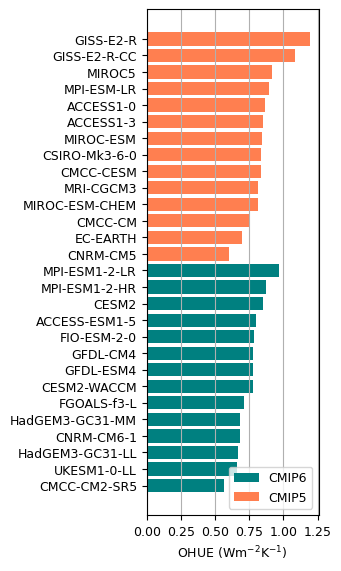

In [71]:
surf_reg=0
OHUE_globe_cmip6 = OHUE.isel(surf_reg=surf_reg).sel(model=models_cmip6)
OHUE_globe_cmip5 = OHUE.isel(surf_reg=surf_reg).sel(model=models_cmip5)

models_cmip6_sorted = list(models_cmip6.sortby(OHUE_globe_cmip6).values)
models_cmip5_sorted = list(models_cmip5.sortby(OHUE_globe_cmip5).values)

OHUE_cmip6_sorted = list(OHUE_globe_cmip6.sortby(OHUE_globe_cmip6).values)
OHUE_cmip5_sorted = list(OHUE_globe_cmip5.sortby(OHUE_globe_cmip5).values)

fig, ax1 = plt.subplots(figsize =(3.3, 5.6),constrained_layout=True)

color = 'black'
ax1.set_xlabel('OHUE (Wm$^{-2}$K$^{-1}$)', color=color,fontsize=9)
ax1.barh(models_cmip6_sorted, OHUE_cmip6_sorted, color='teal')
ax1.barh(models_cmip5_sorted, OHUE_cmip5_sorted, color='coral')
ax1.tick_params(axis='x', labelcolor=color)
ax1.xaxis.grid()
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)
plt.xticks([0,.25,.5,.75,1,1.25])
plt.legend(['CMIP6','CMIP5'],loc=4,fontsize=9)
plt.savefig('OHUE_global.pdf',)

#### Open and define zonal-mean interior fields (N2, density, and slope)

In [72]:
strat_cmip5 = xr.open_dataarray('N2_cmip5.nc').mean('x')
strat_cmip6 = xr.open_dataarray('N2_cmip6.nc').mean('x')

density_cmip5 = xr.open_dataarray('density_cmip5.nc').mean('x')
density_cmip6 = xr.open_dataarray('density_cmip6.nc').mean('x')

drhody_cmip5 = xr.open_dataarray('drhody_cmip5.nc').mean('x')
drhody_cmip6 = xr.open_dataarray('drhody_cmip6.nc').mean('x')
drhodz_cmip5 = xr.open_dataarray('drhodz_cmip5.nc').mean('x')
drhodz_cmip6 = xr.open_dataarray('drhodz_cmip6.nc').mean('x')
slope_cmip5 = (drhodz_cmip5/drhody_cmip5).rename('isopycnal_slope')
slope_cmip6 = (drhodz_cmip6/drhody_cmip6).rename('isopycnal_slope')

strat = xr.concat([strat_cmip5,strat_cmip6],dim='model')
density = xr.concat([density_cmip5,density_cmip6],dim='model')
slope = xr.concat([slope_cmip5, slope_cmip6],dim='model')

####  Calculate $\overline{\rho_{norm}}$ in y, z space

In [45]:
lat = -45

rho_norm = -(density -density.max('lev'))
rho_norm = rho_norm.where(rho_norm<rho_norm.sel(lev=400,method='nearest').sel(y=lat,method='nearest'))
rho_norm = rho_norm/rho_norm.max('lev')
rho_norm= rho_norm.rename('rho_norm')

#### Plot $\overline{\rho_{norm}}$ in y, z space

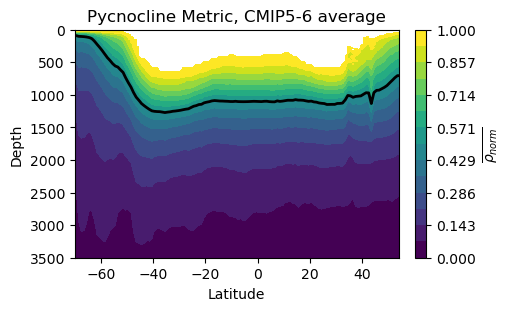

In [46]:
fig = plt.figure(figsize =(5, 3),constrained_layout=True)
rho_norm.mean('model').plot.contourf(levels=15,vmax=1,cbar_kwargs={'label': r'$\overline{\rho_{norm}}$'})
rho_norm.mean('model').plot.contour(levels=[.5],colors='k',linewidths=2)
plt.ylim(3500,0)
plt.title('Pycnocline Metric, CMIP5-6 average')
plt.ylabel('Depth')
plt.xlabel('Latitude')
plt.xlim(-70,54)
plt.savefig('Pyc_metric.pdf')


#### Transform $\overline{\rho_{norm}}(y,z)$ into $z(y,\overline{\rho_{norm}})$ space, to find depth of pycnocline metric

In [77]:
Y=rho_norm.y.values
lev=rho_norm.lev.values
file_lev_bounds = '/gws/nopw/j04/ukfafmip/users/enewsom/regrid_from_jonathan_thetoa/cmip6/CONCATTED/thetao_Oyr_CESM2_piControl_r1i1p1f1_gn_regridded_050001-059912.nc'
dh  = xr.open_dataset(file_lev_bounds).assign_attrs(source_id='CESM2')
dh=combined_preprocessing(dh)
lev_bounds=dh.lev_bounds.isel(bnds=1).values

ds = xr.Dataset(
     coords={
         "y_c": (
             ["y_c"],
             Y,
                   ),
         "y_g": (
             ["y_g"],
             Y+.5, ),
     "lev": (
             ["lev"],
             lev,
         ),
         "lev_g": (
             ["lev_g"],
             lev_bounds)})
grid = Grid(ds, coords={"Y": {"center": "y_c", "right": "y_g"},"lev": {"center": "lev", "right": "lev_g"}},periodic=False)
grid
lev_grid = rho_norm.lev.broadcast_like(rho_norm)
target_levels = np.arange(0,1,.025)
depth_rho_norm = grid.transform(lev_grid, 'lev', target_levels, target_data=rho_norm, method='linear')


/home/users/enewsom/.conda/envs/nbenv2/lib/python3.10/site-packages/numba/np/ufunc/gufunc.py:171: RuntimeWarning: invalid value encountered in _interp_1d_linear
  return self.ufunc(*args, **kwargs)


#### Calculate metrics in SO region and combine into one dataset

In [78]:
pyc_level=.5 #defines pycnocline as rho_norm=.5
lats = slice(-60,60) #latitudes to average the pycnocline

lev_slice = slice(450,700) #depths in SO to average
lat_slice = slice(-57,-47)  #lats in SO to average

#the following defines a grid of dz values for averaging
dz = xr.zeros_like(strat.isel(model=0))
dz0 = np.gradient(strat.lev.broadcast_like(strat.isel(model=0)))[0]
dz.values = dz0
dz_m = dz.sel(lev=lev_slice,y=lat_slice).sum(['lev','y'])

#average metrics and combine
d = depth_rho_norm.sel(rho_norm=pyc_level,method='nearest').sel(y=lats).mean('y')
n = (strat*dz).sel(lev=lev_slice,y=lat_slice).sum(['lev','y'])*1e5/dz_m
s = (slope*dz).sel(lev=lev_slice,y=lat_slice).sum(['lev','y'])*1e3/dz_m
df = xr.merge([OHUE.dropna('model').rename('ohue'),d.rename('depth'),n.rename('N2'),s.rename('slope')])


### Plot metrics (global and OHUE$_{midlats}$)

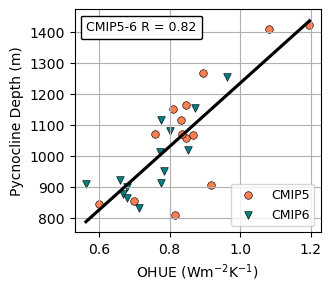

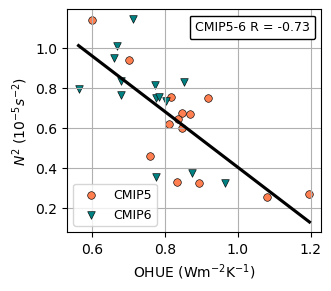

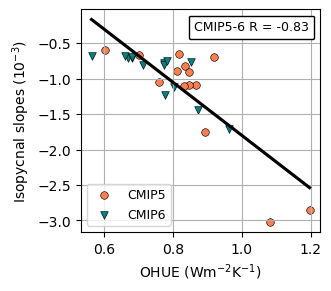

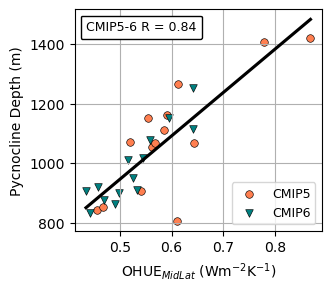

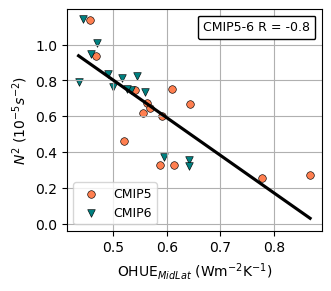

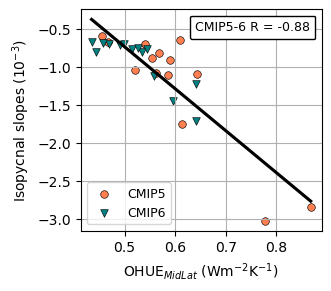

In [85]:
ohue_labels = ['OHUE','OHUE$_{MidLat}$','OHUE$_{NHighLat}$','OHUE$_{SHighLat}$','OHUE$_{LowLat}$']
metric_labels=['Pycnocline Depth (m)','$N^2$ ($10^{-5}s^{-2}$)','Isopycnal slopes ($10^{-3}$)']
reg_abrv = ['global','midlats','NH','SH','LL']

metrics = ['depth','N2','slope']

for surf in range(0,2): #increase range to plot remaining regions
    for j, metric in enumerate(metrics):

        fig, ax = plt.subplots(1,figsize =(3.2,2.8),constrained_layout=True)
        
        reg = reg_abrv[surf]    
        data5 = df.isel(surf_reg=surf).sel(model=models_cmip5) 
        data6 = df.isel(surf_reg=surf).sel(model=models_cmip6)
        data_full = df.isel(surf_reg=surf)
        
        sns.scatterplot(data=data5, x="ohue", y=metric, edgecolor='k',  color="coral",s=30, marker='o')
        sns.scatterplot(data=data6, x="ohue", y=metric,edgecolor='k',  color="teal",s=30, marker='v')
        sns.regplot(x='ohue', y=metric, data=data_full, fit_reg=True,ci=0, ax=ax,scatter=False, color="k")
        
        p = xs.pearson_r_p_value(data_full[metric],data_full.ohue,dim='model',skipna=True )
        r = xr.corr(data_full[metric],data_full.ohue)

        if r.values <0:
            loc1 = 3
            loc2 =1
        else:
            loc1 = 4
            loc2 = 2
        plt.legend(['CMIP5','CMIP6'],fontsize=9,loc=loc1)
        at = textonly(plt.gca(), 'CMIP5-6 R = '+str(np.round(r.values,2)),fontsize=9,loc=loc2) 

        plt.ylabel(metric_labels[j])
        plt.xlabel(ohue_labels[surf]+' (Wm$^{-2}$K$^{-1}$)') 
        plt.grid()
        
        #plt.savefig('OHUE_metrics_plot_'+metric+'_'+reg+'.pdf')